In [1]:
from __future__ import annotations

from helper import generate_2d_ising_error_data, plot_error_vs_depth

Define parameters

In [ ]:
J = 1
g = 1
dt = 0.1
num_rows = 4
num_cols = 4
pad = 1

min_bonds = [2, 4, 8, 16]
thresholds = [0]
# max_bonds = [64]
# timesteps_list = [1, 5, *range(10, 110, 10)]
timesteps_list = [*range(1, 6)]

In [3]:
results = generate_2d_ising_error_data(num_rows, num_cols, J, g, dt, min_bonds, timesteps_list)

Timesteps 1
Timesteps 2
Timesteps 3
Timesteps 4
Timesteps 5
Timesteps 1
Timesteps 2
Timesteps 3
Timesteps 4
Timesteps 5
Timesteps 1
Timesteps 2
Timesteps 3
Timesteps 4
Timesteps 5
Timesteps 1
Timesteps 2
Timesteps 3
Timesteps 4
Timesteps 5
Timesteps 1
Timesteps 2
Timesteps 3
Timesteps 4
Timesteps 5


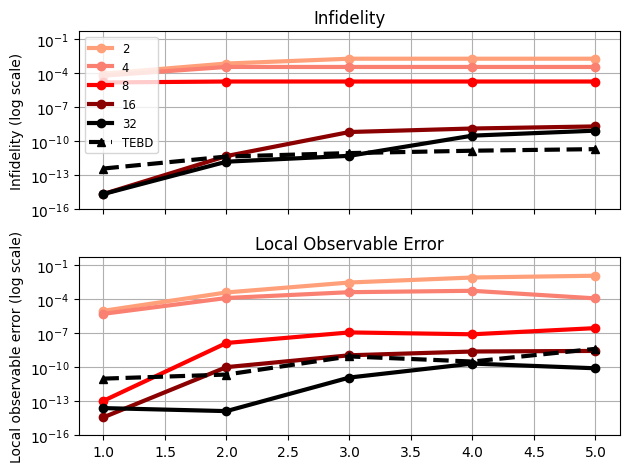

In [4]:
plot_error_vs_depth(results, min_bonds)